In [72]:
import torch
import clip
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

default
colors
shininess
light_front
_mirror
antimirror
resolution
side
colorful


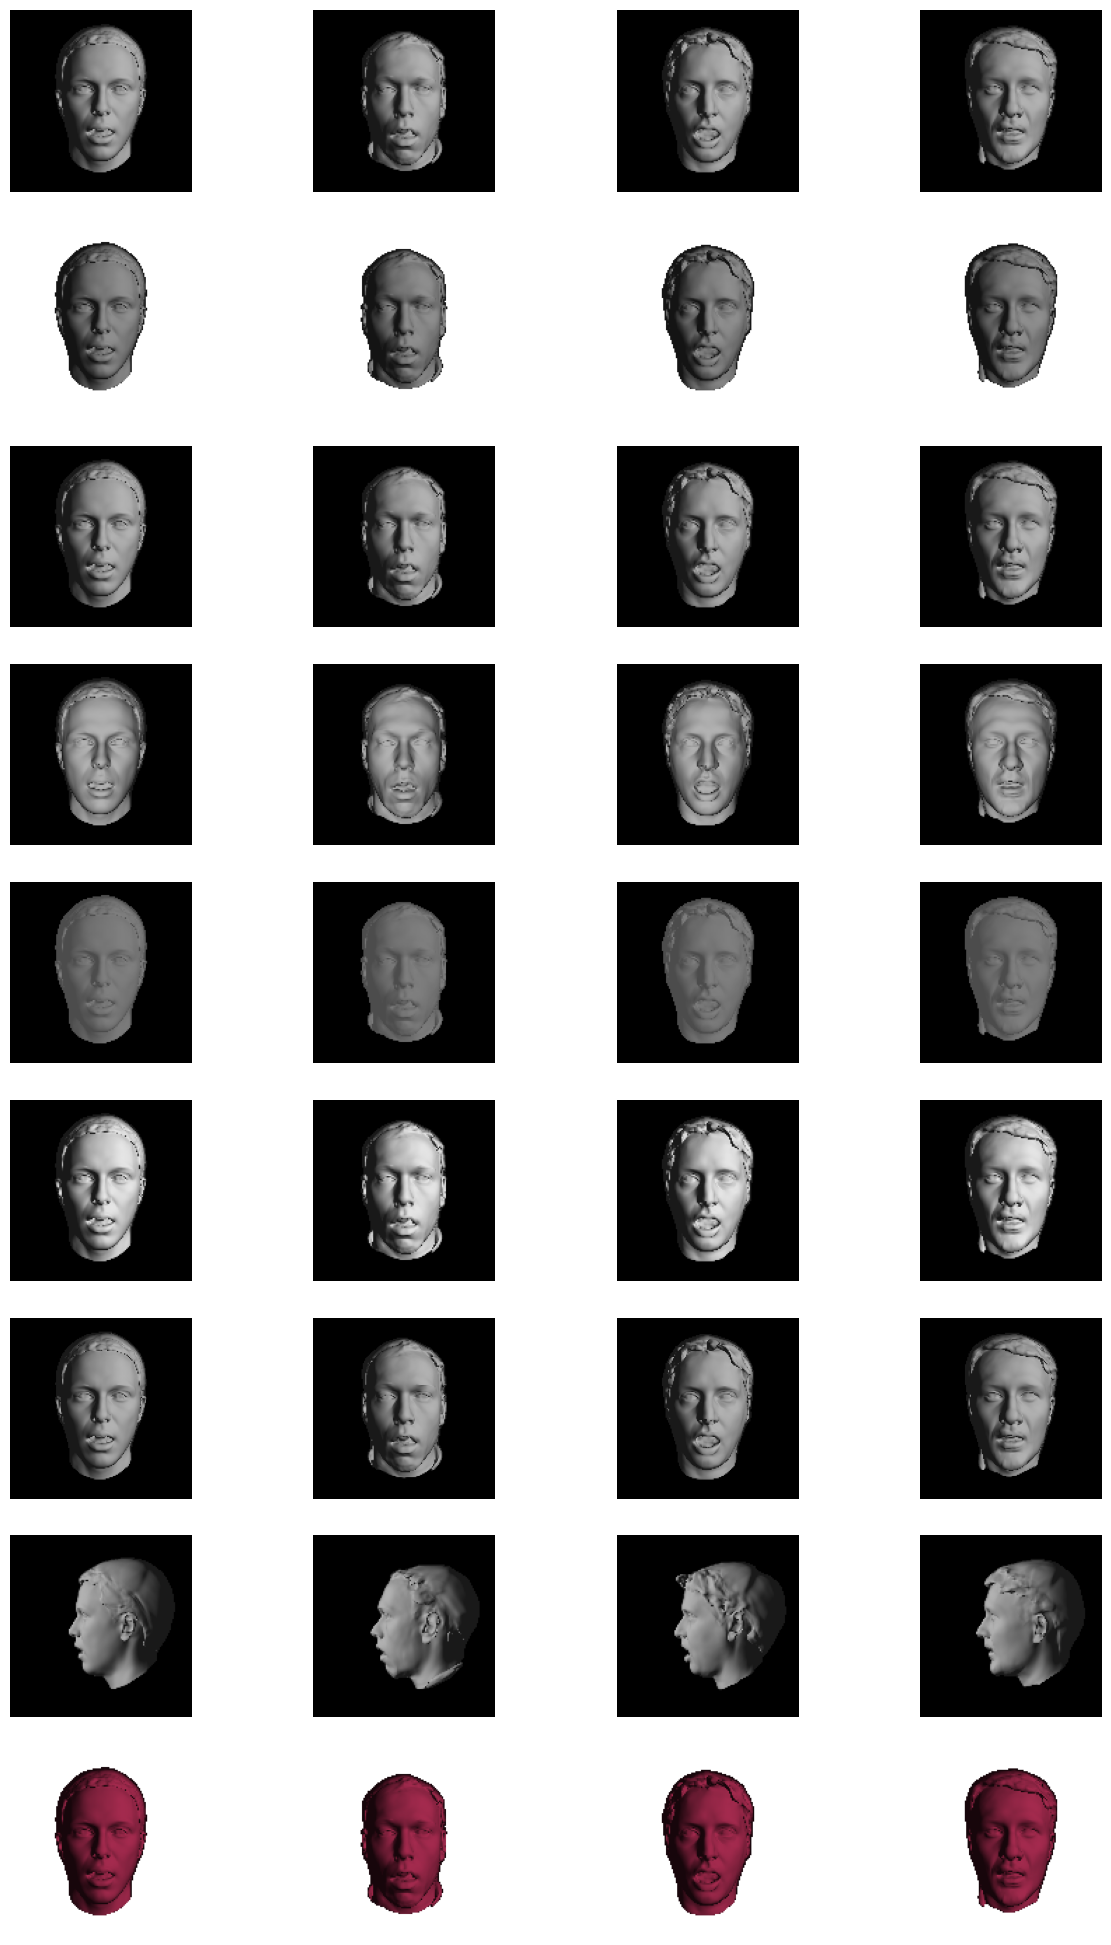

torch.Size([36, 3, 224, 224])


In [66]:
# image inputs
image_folder = '/Users/katharinaschmid/Text2Head/NPHM-main/rendering_data'

images = []
preprocessed_images = torch.tensor([])
file_list = sorted(os.listdir(image_folder))

keys = ['default', 'colors', 'shininess', 'light_front', '_mirror', 'antimirror', 'resolution', 'side', 'colorful']
for key in keys:
    print(key)
    for filename in file_list:
        if filename.endswith(key + ".png"):
            image = Image.open(os.path.join(image_folder, filename))
            images.append(image)
            preprocessed_image = preprocess(image).unsqueeze(0) # [1, 3, 224, 224]
            preprocessed_images = torch.cat((preprocessed_images, preprocessed_image), dim=0)
num_images = len(images)

fig, axes = plt.subplots(len(keys), 4, figsize=(15, 25))
for i, img in enumerate(images):
    ax = axes[i//4, i%4]
    ax.imshow(img)  # Display each image
    ax.axis('off')  # Turn off axis labels

plt.show()
print(preprocessed_images.shape)

# Individual Sensitivity of Parameters
Result: In general, the tests "colorful" and "antimirror" performed better than default.
A small increase in resolution doesn't lead to better results. All other tests lead to worse performance.

In [106]:
# text inputs
general = "An image of the bust of "
captions = []
captions.append(general + "a young man")
captions.append(general + "an Asian young man")
captions.append(general + "a young man with wide forehead")
captions.append(general + "a young man with long, curly hair")
captions.append(general + "a young man with a big nose")
captions.append(general + "a chubby man")
captions.append(general + "a woman")


preprocessed_text = clip.tokenize(captions).to(device) # [num_captions, 77]

with torch.no_grad():
    image_features = model.encode_image(preprocessed_images) # [num_images, 512]
    text_features = model.encode_text(preprocessed_text) # [num_captions, 512]

# Normalize
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

cosine_similarity = torch.matmul(image_features, text_features.T)
cosine_similarity = cosine_similarity.reshape(-1, 4, len(captions)) # [tests, images, captions]
print(cosine_similarity.shape)

num_tests = cosine_similarity.shape[0]
print(num_tests)

for c in range(len(captions)):
    print('Test: ', captions[c])
    sim_np = cosine_similarity[:, :, c].squeeze(-1).numpy()
    row_labels = [keys[test] for test in range(num_tests)]
    col_labels = [f"Image_{i}" for i in range(4)]
    df = pd.DataFrame(sim_np, index=row_labels, columns=col_labels)
    
    # Let's analyze!
    df['Max_Image'] = df.idxmax(axis=1, numeric_only=True)
    df['Min_Image'] = df.idxmin(axis=1, numeric_only=True)
    df['Max_Value'] = df.max(axis=1, numeric_only=True)
    df['Min_Value'] = df.min(axis=1, numeric_only=True)
    
    df['Max_Delta'] = df['Max_Value'] - df['Min_Value']
    df['Max_Ratio'] = df['Min_Value'] / df['Max_Value']
    print(df)
    
    top_delta = df.nlargest(3, 'Max_Delta').index.tolist()
    top_ratio = df.nsmallest(3, 'Max_Ratio').index.tolist()
    print("Test names of the top 3 rows with highest Delta values:", top_delta)
    print("Test names of the top 3 rows with lowest Ratio values:", top_delta)

torch.Size([9, 4, 7])
9
Test:  An image of the bust of a young man
              Image_0   Image_1   Image_2   Image_3 Max_Image Min_Image  \
default      0.284021  0.264851  0.288673  0.301514   Image_3   Image_1   
colors       0.277088  0.263626  0.271299  0.284861   Image_3   Image_1   
shininess    0.284021  0.264851  0.288673  0.301514   Image_3   Image_1   
light_front  0.301794  0.280721  0.292251  0.307947   Image_3   Image_1   
_mirror      0.289002  0.276251  0.285993  0.305197   Image_3   Image_1   
antimirror   0.280265  0.260155  0.289659  0.303183   Image_3   Image_1   
resolution   0.295246  0.269695  0.287769  0.305226   Image_3   Image_1   
side         0.269803  0.278523  0.286705  0.274602   Image_2   Image_0   
colorful     0.261243  0.230735  0.265238  0.282981   Image_3   Image_1   

             Max_Value  Min_Value  Max_Delta  Max_Ratio  
default       0.301514   0.264851   0.036663   0.878404  
colors        0.284861   0.263626   0.021235   0.925456  
shinines

# Influence of combining image features
1) Combine all tests
--> Leads to worse performance
2) Combine top performing tests
--> Leads to a slight improvement

In [118]:
image_features_reshaped = image_features.reshape(-1, 4, 512)

# Average over all tests
image_features_avg = image_features_reshaped.sum(dim=0)
image_features_avg = image_features_avg / image_features_avg.norm(dim=-1, keepdim=True)

cosine_similarity_avg = torch.matmul(image_features_avg, text_features.T)
print('Average over all tests')
sim_avg_np = cosine_similarity_avg.T.numpy()
row_labels = [f"Caption_{i}" for i in range(len(captions))] #[captions[test] for test in range(len(captions))]
col_labels = [f"Image_{i}" for i in range(4)]
df_avg = pd.DataFrame(sim_avg_np, index=row_labels, columns=col_labels)

# Let's analyze!
df_avg['Max_Image'] = df_avg.idxmax(axis=1, numeric_only=True)
df_avg['Min_Image'] = df_avg.idxmin(axis=1, numeric_only=True)
df_avg['Max_Value'] = df_avg.max(axis=1, numeric_only=True)
df_avg['Min_Value'] = df_avg.min(axis=1, numeric_only=True)

df_avg['Max_Delta'] = df_avg['Max_Value'] - df_avg['Min_Value']
df_avg['Max_Ratio'] = df_avg['Min_Value'] / df_avg['Max_Value']
print(df_avg)

#############
print('#########################')

# Average over top tests
image_features_top = torch.stack((image_features_reshaped[0, :, :], image_features_reshaped[5, :, :], image_features_reshaped[8, :, :]), dim=0)
image_features_avg_top = image_features_top.sum(dim=0)
image_features_avg_top = image_features_avg_top / image_features_avg_top.norm(dim=-1, keepdim=True)
cosine_similarity_avg_top = torch.matmul(image_features_avg_top, text_features.T)
print('Average over top tests')
sim_avg_top_np = cosine_similarity_avg_top.T.numpy()
row_labels = [f"Caption_{i}" for i in range(len(captions))] #[captions[test] for test in range(len(captions))]
col_labels = [f"Image_{i}" for i in range(4)]
df_avg_top = pd.DataFrame(sim_avg_top_np, index=row_labels, columns=col_labels)

# Let's analyze!
df_avg_top['Max_Image'] = df_avg_top.idxmax(axis=1, numeric_only=True)
df_avg_top['Min_Image'] = df_avg_top.idxmin(axis=1, numeric_only=True)
df_avg_top['Max_Value'] = df_avg_top.max(axis=1, numeric_only=True)
df_avg_top['Min_Value'] = df_avg_top.min(axis=1, numeric_only=True)

df_avg_top['Max_Delta'] = df_avg_top['Max_Value'] - df_avg_top['Min_Value']
df_avg_top['Max_Ratio'] = df_avg_top['Min_Value'] / df_avg_top['Max_Value']
print(df_avg_top)

Average over all tests
            Image_0   Image_1   Image_2   Image_3 Max_Image Min_Image  \
Caption_0  0.291743  0.276750  0.293127  0.306968   Image_3   Image_1   
Caption_1  0.290739  0.282717  0.286260  0.313955   Image_3   Image_1   
Caption_2  0.305588  0.290143  0.299206  0.311694   Image_3   Image_1   
Caption_3  0.246713  0.221712  0.263658  0.257823   Image_2   Image_1   
Caption_4  0.301159  0.286497  0.302226  0.315621   Image_3   Image_1   
Caption_5  0.298036  0.305841  0.315036  0.327631   Image_3   Image_0   
Caption_6  0.268338  0.249876  0.280652  0.288774   Image_3   Image_1   

           Max_Value  Min_Value  Max_Delta  Max_Ratio  
Caption_0   0.306968   0.276750   0.030219   0.901557  
Caption_1   0.313955   0.282717   0.031238   0.900503  
Caption_2   0.311694   0.290143   0.021551   0.930859  
Caption_3   0.263658   0.221712   0.041946   0.840908  
Caption_4   0.315621   0.286497   0.029124   0.907724  
Caption_5   0.327631   0.298036   0.029595   0.909669  


# Delta analysis
CLIP(img) - CLIP(avg_img) leads to a much stronger signal!
--> antimirror + colorful better than default in all (7 and 6) cases
--> light_front, resolution and _mirror better in 3, 3, 2 cases

In [119]:
image_features_delta = image_features_reshaped[:, 1:, :] - image_features_reshaped[:, 0, :].unsqueeze(1)

image_features_delta_norm = image_features_delta / image_features_delta.norm(dim=-1, keepdim=True)
image_features_delta_norm = image_features_delta_norm.reshape(-1, 512)
cosine_similarity_delta = torch.matmul(image_features_delta_norm, text_features.T)
cosine_similarity_delta = cosine_similarity_delta.reshape(-1, 3, len(captions))

for c in range(len(captions)):
    print('Test: ', captions[c])
    sim_delta_np = cosine_similarity_delta[:, :, c].squeeze(-1).numpy()
    row_labels = [keys[test] for test in range(num_tests)]
    col_labels = [f"Image_{i}" for i in range(3)]
    df_delta = pd.DataFrame(sim_delta_np, index=row_labels, columns=col_labels)
    
    # Let's analyze!
    df_delta['Max_Image'] = df_delta.idxmax(axis=1, numeric_only=True)
    df_delta['Min_Image'] = df_delta.idxmin(axis=1, numeric_only=True)
    df_delta['Max_Value'] = df_delta.max(axis=1, numeric_only=True)
    df_delta['Min_Value'] = df_delta.min(axis=1, numeric_only=True)
    
    df_delta['Max_Delta'] = df_delta['Max_Value'] - df_delta['Min_Value']
    df_delta['Max_Ratio'] = df_delta['Min_Value'] / df_delta['Max_Value']
    print(df_delta)
    
    top_delta = df_delta.nlargest(3, 'Max_Delta').index.tolist()
    top_ratio = df_delta.nsmallest(3, 'Max_Ratio').index.tolist()
    print("Test names of the top 3 rows with highest Delta values:", top_delta)
    print("Test names of the top 3 rows with lowest Ratio values:", top_delta)

Test:  An image of the bust of a young man
              Image_0   Image_1   Image_2 Max_Image Min_Image  Max_Value  \
default     -0.045750  0.014579  0.040349   Image_2   Image_0   0.040349   
colors      -0.035281 -0.018882  0.020039   Image_2   Image_0   0.020039   
shininess   -0.045750  0.014579  0.040349   Image_2   Image_0   0.040349   
light_front -0.065905 -0.036347  0.021155   Image_2   Image_0   0.021155   
_mirror     -0.035672 -0.011578  0.048181   Image_2   Image_0   0.048181   
antimirror  -0.042837  0.027573  0.047700   Image_2   Image_0   0.047700   
resolution  -0.061435 -0.028219  0.027355   Image_2   Image_0   0.027355   
side         0.028467  0.045398  0.018030   Image_1   Image_2   0.045398   
colorful    -0.068126  0.012010  0.056979   Image_2   Image_0   0.056979   

             Min_Value  Max_Delta  Max_Ratio  
default      -0.045750   0.086099  -1.133850  
colors       -0.035281   0.055320  -1.760576  
shininess    -0.045750   0.086099  -1.133850  
light_fr

# Text input reduced to difference in combination with Delta Analysis
--> significantly worse performance

In [122]:
captions_diff = []
captions_diff.append("young, male")
captions_diff.append("Asian young man")
captions_diff.append("young man with wide forehead")
captions_diff.append("young man with long, curly hair")
captions_diff.append("young man with big nose")
captions_diff.append("chubby man")
captions_diff.append("woman")

preprocessed_text_diff = clip.tokenize(captions_diff).to(device)

with torch.no_grad():
    text_features_diff = model.encode_text(preprocessed_text_diff) # [num_captions, 512]

# Normalize
text_features_diff /= text_features_diff.norm(dim=-1, keepdim=True)

cosine_similarity_delta_diff = torch.matmul(image_features_delta_norm, text_features_diff.T)
cosine_similarity_delta_diff = cosine_similarity_delta_diff.reshape(-1, 3, len(captions))

for c in range(len(captions)):
    print('Test: ', captions_diff[c])
    sim_delta_diff_np = cosine_similarity_delta_diff[:, :, c].squeeze(-1).numpy()
    row_labels = [keys[test] for test in range(num_tests)]
    col_labels = [f"Image_{i}" for i in range(3)]
    df_delta_diff = pd.DataFrame(sim_delta_diff_np, index=row_labels, columns=col_labels)
    
    # Let's analyze!
    df_delta_diff['Max_Image'] = df_delta_diff.idxmax(axis=1, numeric_only=True)
    df_delta_diff['Min_Image'] = df_delta_diff.idxmin(axis=1, numeric_only=True)
    df_delta_diff['Max_Value'] = df_delta_diff.max(axis=1, numeric_only=True)
    df_delta_diff['Min_Value'] = df_delta_diff.min(axis=1, numeric_only=True)
    
    df_delta_diff['Max_Delta'] = df_delta_diff['Max_Value'] - df_delta_diff['Min_Value']
    df_delta_diff['Max_Ratio'] = df_delta_diff['Min_Value'] / df_delta_diff['Max_Value']
    print(df_delta_diff)
    
    top_delta = df_delta_diff.nlargest(3, 'Max_Delta').index.tolist()
    top_ratio = df_delta_diff.nsmallest(3, 'Max_Ratio').index.tolist()
    print("Test names of the top 3 rows with highest Delta values:", top_delta)
    print("Test names of the top 3 rows with lowest Ratio values:", top_delta)

Test:  young, male
              Image_0   Image_1   Image_2 Max_Image Min_Image  Max_Value  \
default     -0.047694 -0.014313 -0.027225   Image_1   Image_0  -0.014313   
colors      -0.026555 -0.004719 -0.038516   Image_1   Image_2  -0.004719   
shininess   -0.047694 -0.014313 -0.027225   Image_1   Image_0  -0.014313   
light_front -0.041945 -0.021464 -0.026143   Image_1   Image_0  -0.021464   
_mirror     -0.020428  0.009232 -0.012420   Image_1   Image_0   0.009232   
antimirror  -0.042800 -0.017390 -0.027112   Image_1   Image_0  -0.017390   
resolution  -0.045475 -0.025019 -0.028185   Image_1   Image_0  -0.025019   
side        -0.035467 -0.017093 -0.014030   Image_2   Image_0  -0.014030   
colorful    -0.036348 -0.001451 -0.017770   Image_1   Image_0  -0.001451   

             Min_Value  Max_Delta  Max_Ratio  
default      -0.047694   0.033381   3.332250  
colors       -0.038516   0.033796   8.161628  
shininess    -0.047694   0.033381   3.332250  
light_front  -0.041945   0.02048

# Delta Analysis + avg over promising tests
--> performance better than default delta but worse than antimirror, colorful

In [126]:
# default, antimirror, colorful
image_features_delta_norm = image_features_delta / image_features_delta.norm(dim=-1, keepdim=True)

image_features_top_delta = torch.stack((image_features_delta_norm[0, :, :], image_features_delta_norm[5, :, :], image_features_delta_norm[8, :, :]), dim=0)
image_features_avg_top_delta = image_features_top_delta.sum(dim=0)
image_features_avg_top_delta = image_features_avg_top_delta / image_features_avg_top_delta.norm(dim=-1, keepdim=True)

cosine_similarity_avg_top_delta = torch.matmul(image_features_avg_top_delta, text_features.T)
print('Average over top tests')
sim_avg_top_delta_np = cosine_similarity_avg_top_delta.T.numpy()
row_labels = [f"Caption_{i}" for i in range(len(captions))] #[captions[test] for test in range(len(captions))]
col_labels = [f"Image_{i}" for i in range(3)]
df_avg_top_delta = pd.DataFrame(sim_avg_top_delta_np, index=row_labels, columns=col_labels)

# Let's analyze!
df_avg_top_delta['Max_Image'] = df_avg_top_delta.idxmax(axis=1, numeric_only=True)
df_avg_top_delta['Min_Image'] = df_avg_top_delta.idxmin(axis=1, numeric_only=True)
df_avg_top_delta['Max_Value'] = df_avg_top_delta.max(axis=1, numeric_only=True)
df_avg_top_delta['Min_Value'] = df_avg_top_delta.min(axis=1, numeric_only=True)

df_avg_top_delta['Max_Delta'] = df_avg_top_delta['Max_Value'] - df_avg_top_delta['Min_Value']
df_avg_top_delta['Max_Ratio'] = df_avg_top_delta['Min_Value'] / df_avg_top_delta['Max_Value']
print(df_avg_top_delta)

Average over top tests
            Image_0   Image_1   Image_2 Max_Image Min_Image  Max_Value  \
Caption_0 -0.057394  0.020784  0.052563   Image_2   Image_0   0.052563   
Caption_1 -0.034035  0.003965  0.076024   Image_2   Image_0   0.076024   
Caption_2 -0.062686 -0.010698  0.018977   Image_2   Image_0   0.018977   
Caption_3 -0.080876  0.078653  0.041874   Image_1   Image_0   0.078653   
Caption_4 -0.055694  0.019818  0.050496   Image_2   Image_0   0.050496   
Caption_5  0.012297  0.087318  0.095912   Image_2   Image_0   0.095912   
Caption_6 -0.054200  0.082164  0.077892   Image_1   Image_0   0.082164   

           Min_Value  Max_Delta  Max_Ratio  
Caption_0  -0.057394   0.109956  -1.091909  
Caption_1  -0.034035   0.110059  -0.447679  
Caption_2  -0.062686   0.081663  -3.303203  
Caption_3  -0.080876   0.159529  -1.028265  
Caption_4  -0.055694   0.106190  -1.102935  
Caption_5   0.012297   0.083615   0.128208  
Caption_6  -0.054200   0.136364  -0.659653  


In [ ]:
# OLD CODE, NO USE FOR NOW

fig, ax = plt2.subplots()
im = ax.imshow(cosine_similarity, cmap='gray')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(images)))
ax.set_yticks(np.arange(len(captions)), labels=captions)

# Rotate the tick labels and set their alignment.
plt2.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(captions)):
    for j in range(len(images)):
        similarity = cosine_similarity[i, j].numpy()
        formatted_similarity = "{:.3f}".format(similarity)  # Limit to 2 decimal places
        text = ax.text(j, i, formatted_similarity,
                       ha="center", va="center", color="r")

ax.set_title("Cosine Similarity")
fig.tight_layout()
plt2.show()